In [1]:
import os
import sys
sys.path.append("../")

import tensorflow as tf
from glob import glob
from typing import List
from matplotlib import pyplot as plt
import numpy as np
from numpy import ndarray
from typing import Dict, List, Union
from rosbag2numpy import config as params
from rosbag2numpy.data_processing.data_loader_fv import dataset_loader
import time
from tqdm import trange

print(tf.__version__)


2.3.0


In [2]:
ds_loader = dataset_loader(
    tfrec_dir=params.get("data_dir"),
    #'/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_bgm_fv_diff_unequal',#params.get("data_dir"),
    batch_size=32,
    shuffle_buffer=3200,
    normalize_coords=True,
    normalize_factor=1536.0
)
ds_train, ds_valid, ds_test, ds_test_all = ds_loader.build_scenario_dataset(no_train_scene=8,no_valid_scene=1,no_test_scene=1)

Scenarios:['/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_cm_fv_diff_unequal/scenario1', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_cm_fv_diff_unequal/scenario2', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_cm_fv_diff_unequal/scenario3', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_cm_fv_diff_unequal/scenario4', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_cm_fv_diff_unequal/scenario5', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_cm_fv_diff_unequal/scenario_ph_11', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_cm_fv_diff_unequal/scenario_ph_12', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_cm_fv_diff_unequal/scenario_ph_13', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_cm_fv_diff_unequal/scenario_ph_14', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_cm_fv_diff_unequal/scenario_ph_15']
Test scenario:['/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_c

In [48]:
from tensorflow.keras import layers
from tensorflow.keras import models
import tensorflow as tf

def _get_optimizer(opt_name: str = "nadam", lr: float = 0.02):
    if opt_name == "adam":
        return tf.keras.optimizers.Adam(learning_rate=lr)
    elif opt_name == "sgd":
        return tf.keras.optimizers.SGD(learning_rate=lr)
    elif opt_name == "rmsprop":
        return tf.keras.optimizers.RMSprop(learning_rate=lr)
    elif opt_name == "adagrad":
        return tf.keras.optimizers.Adagrad(learning_rate=lr)
    elif opt_name == "adadelta":
        return tf.keras.optimizers.Adadelta(learning_rate=lr)
    elif opt_name == "adamax":
        return tf.keras.optimizers.Adamax(learning_rate=lr)
    elif opt_name == "nadam":
        return tf.keras.optimizers.Nadam(learning_rate=lr)
    else:
        return tf.keras.optimizers.Nadam(learning_rate=lr)


def net():
    ip_fv = layers.Input(shape=(25,1040))
    #x_A = layers.TimeDistributed(layers.Dense(units=64,activity_regularizer = tf.keras.regularizers.l2(0.01)))(ip_fv)
    #x_A = layers.TimeDistributed(layers.Dense(units=2,activation='tanh'))(x_A)

    x_A = layers.LSTM(units=2,return_sequences=True)(ip_fv)

    #x_A = layers.LSTM(units=50)(x_A)
    x_A = layers.TimeDistributed(layers.Dense(units=2,activation='tanh'))(x_A)

    #x_A = layers.Reshape(target_shape=(25,2))(x_A)

    nn_fun = models.Model(inputs = ip_fv, outputs= x_A)

    nn_fun.summary()

    return nn_fun

fv_model = net()

fv_model.compile(
    optimizer=_get_optimizer(opt_name='rms'), 
    loss='mae', metrics='mse')

# Learning rate scheduler
cb_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3, min_lr=0.0001
)

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 25, 1040)]        0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 25, 2)             8344      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 25, 2)             6         
Total params: 8,350
Trainable params: 8,350
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = fv_model.fit(ds_train,epochs=90,validation_data=ds_valid,verbose=1, 
                            callbacks=[cb_reduce_lr])

In [50]:
test_loss,test_acc = fv_model.evaluate(ds_test)

5/5 [==============================] - 0s 7ms/step - loss: 4.3442e-04 - mse: 1.0239e-06


## Evaluation

In [3]:
def _get_test_ds_size(ds_test) -> int:
    """get the size of test dataset

    Args:
        ds_test (tf.data.Dataset): [description]

    Returns:
        [int]: [Number of Samples inside dataset]
    """
    num_of_samples = 0
    # Looping through all batches in test dataset
    for input_batch, output_batch in ds_test:
        # Looping through all samples for a single (current) batch
        #print(input_batch[0].numpy().shape)
        for i in range(0, len(input_batch[0].numpy())):
            num_of_samples += 1
    return num_of_samples


def get_np_test_ds(ds_test) -> Dict[str, Union[ndarray, List]]:
    """Test dataset (in tf.data.Dataset build) to numpy arrays

    Args:
        ds_test ([type]): tf.data.Dataset

    Returns:
        Dict[str,Union[ndarray,List]]: dictionary of feature_vector,costmap,init_path,opt_path,car_odo,file_details,unequal_indices, diff_path
    """
    samples = _get_test_ds_size(ds_test)
    np_tst_feature_vector = np.zeros(shape=(samples,25,1040))
    np_tst_costmap = np.zeros(shape=(samples, 1536, 1536)).astype(np.float16)
    
    #np_tst_left_bnd = np.zeros(shape=(samples, 25, 2))
    #np_tst_right_bnd = np.zeros(shape=(samples, 25, 2))
    np_tst_car_odo = np.zeros(shape=(samples, 2))
    np_tst_init_path = np.zeros(shape=(samples, 25, 2))
    np_tst_opt_path = np.zeros(shape=(samples, 25, 2))
    list_tst_file_details = []

    #list_unequal_indices = []

    #output
    np_tst_diff_path = np.zeros(shape=(samples, 25, 2))

    j = 0
    for input_batch, output_batch in ds_test:

        for i in range(len(input_batch[0].numpy())):
            np_tst_feature_vector[j] = input_batch[0][i].numpy()
            np_tst_costmap[j] = input_batch[1][i].numpy().astype(np.float16)
            #np_tst_grid_org_res[j] = input_batch[1][i].numpy()
            #np_tst_left_bnd[j] = input_batch[2][i].numpy()
            #np_tst_right_bnd[j] = input_batch[3][i].numpy()
            np_tst_init_path[j] = input_batch[2][i].numpy()
            np_tst_opt_path[j] = input_batch[3][i].numpy()
            np_tst_car_odo[j] = input_batch[4][i].numpy()
            list_tst_file_details.append(input_batch[5][i])
            #list_unequal_indices.append(input_batch[6][i])

            #np_tst_opt_path[j] = output_batch[i].numpy()
            np_tst_diff_path[j] = output_batch[i].numpy()
            j = j + 1

    np_ds_test = {
        "feature_vector": np_tst_feature_vector,
        "cost_map": np_tst_costmap,
        #"grid_org_res": np_tst_grid_org_res,
        #"left_bnd": np_tst_left_bnd,
        #"right_bnd": np_tst_right_bnd,
        "init_path": np_tst_init_path,
        "opt_path": np_tst_opt_path,
        "car_odo": np_tst_car_odo,
        "file_details": list_tst_file_details,
        #"unequal_indices": list_unequal_indices,
        "diff_path": np_tst_diff_path,

    }

    # np_tst_gridmap,np_tst_grid_org_res,np_tst_left_bnd,np_tst_right_bnd,np_tst_car_odo,np_tst_init_path,list_tst_file_details,np_tst_opt_path
    return np_ds_test


In [4]:
np_test_ds_all = get_np_test_ds(ds_test=ds_test_all)

In [65]:
cost_map = np_test_ds_all["cost_map"]
feature_v = np_test_ds_all["feature_vector"]
init_path = np_test_ds_all["init_path"]
opt_path = np_test_ds_all["opt_path"]
car_odo = np_test_ds_all["car_odo"]
file_details = np_test_ds_all["file_details"]
diff_path = np_test_ds_all["diff_path"]

In [6]:
feature_v.shape

(144, 25, 1040)

In [6]:
"""
    loaded_TimedistrModel = tf.keras.models.load_model('/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/TimedistributedDenseModel.h5')
    predictions = loaded_TimedistrModel.predict(feature_v)
    predicted_paths = init_path - predictions
    predicted_paths.shape
"""


(144, 25, 2)

In [ ]:
predictions = fv_model.predict(feature_v)
predicted_paths = init_path - predictions
predicted_paths.shape

## Load pre trained model

In [8]:


wandbmodel_path = '/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/wandb/run-20210922_162541-2bwn3ku4/files/model-best.h5'
#'/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/wandb/run-20210922_162541-2bwn3ku4/files/model-best.h5'
#'/netpool/work/gpu-3/users/malyalasa/New_folder/wandb/run-20210922_010110-1sb0es02/files/model-best.h5'
#'/netpool/work/gpu-3/users/malyalasa/New_folder/wandb/run-20210921_225739-3tq5o6wv/files/model-best.h5'
#'/netpool/work/gpu-3/users/malyalasa/New_folder/wandb/run-20210921_223929-2789gz0e/files/model-best.h5'
#'/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/wandb/run-20210922_154305-30js7pw0/files/model-best.h5'
load_wandb  = tf.keras.models.load_model(wandbmodel_path)
predictions = load_wandb.predict(feature_v)
predicted_paths = init_path - predictions
predicted_paths.shape

(144, 25, 2)

## Iterative robustness check

In [75]:
def get_feature_vector(gridmap:ndarray,init_path:ndarray,offset)->ndarray:
    feature_vector = np.zeros(shape=(init_path.shape[0],4*offset[0]*offset[1]))
    # np.array(init_path.shape[0],4*offset[0]*offset[1])
    for i in range(init_path.shape[0]):
        x_l,y_l = (init_path[i].astype(int)) - offset
        x_h,y_h = (init_path[i].astype(int)) + offset
        cell = 0
        #print("lower:",(x_l,y_l))
        #print("higher:",(x_h,y_h))

        for x in range(x_l,x_h):
            for y in range(y_l,y_h):
                #print(x,y)
                if cell<feature_vector.shape[1]:
                    #gridmap[row][column]
                    feature_vector[i][cell] = gridmap[y][x]
                    cell+=1
    return feature_vector


id=48
sample_init = np_test_ds_all["init_path"][id]
sample_opt = np_test_ds_all["opt_path"][id]
sample_gm = np_test_ds_all["cost_map"][id]
sample_odo = np_test_ds_all["car_odo"][id]
sample_fv = np_test_ds_all["feature_vector"][id]
sample_gt_diff = np_test_ds_all["diff_path"][id]
sample_file_details = np_test_ds_all["file_details"][id]
#model_output = load_wandb.predict(np.expand_dims(sample_fv,axis=0))
#model_path = (sample_init -model_output)[0]

100%|██████████| 1/1 [00:00<00:00,  8.67it/s]


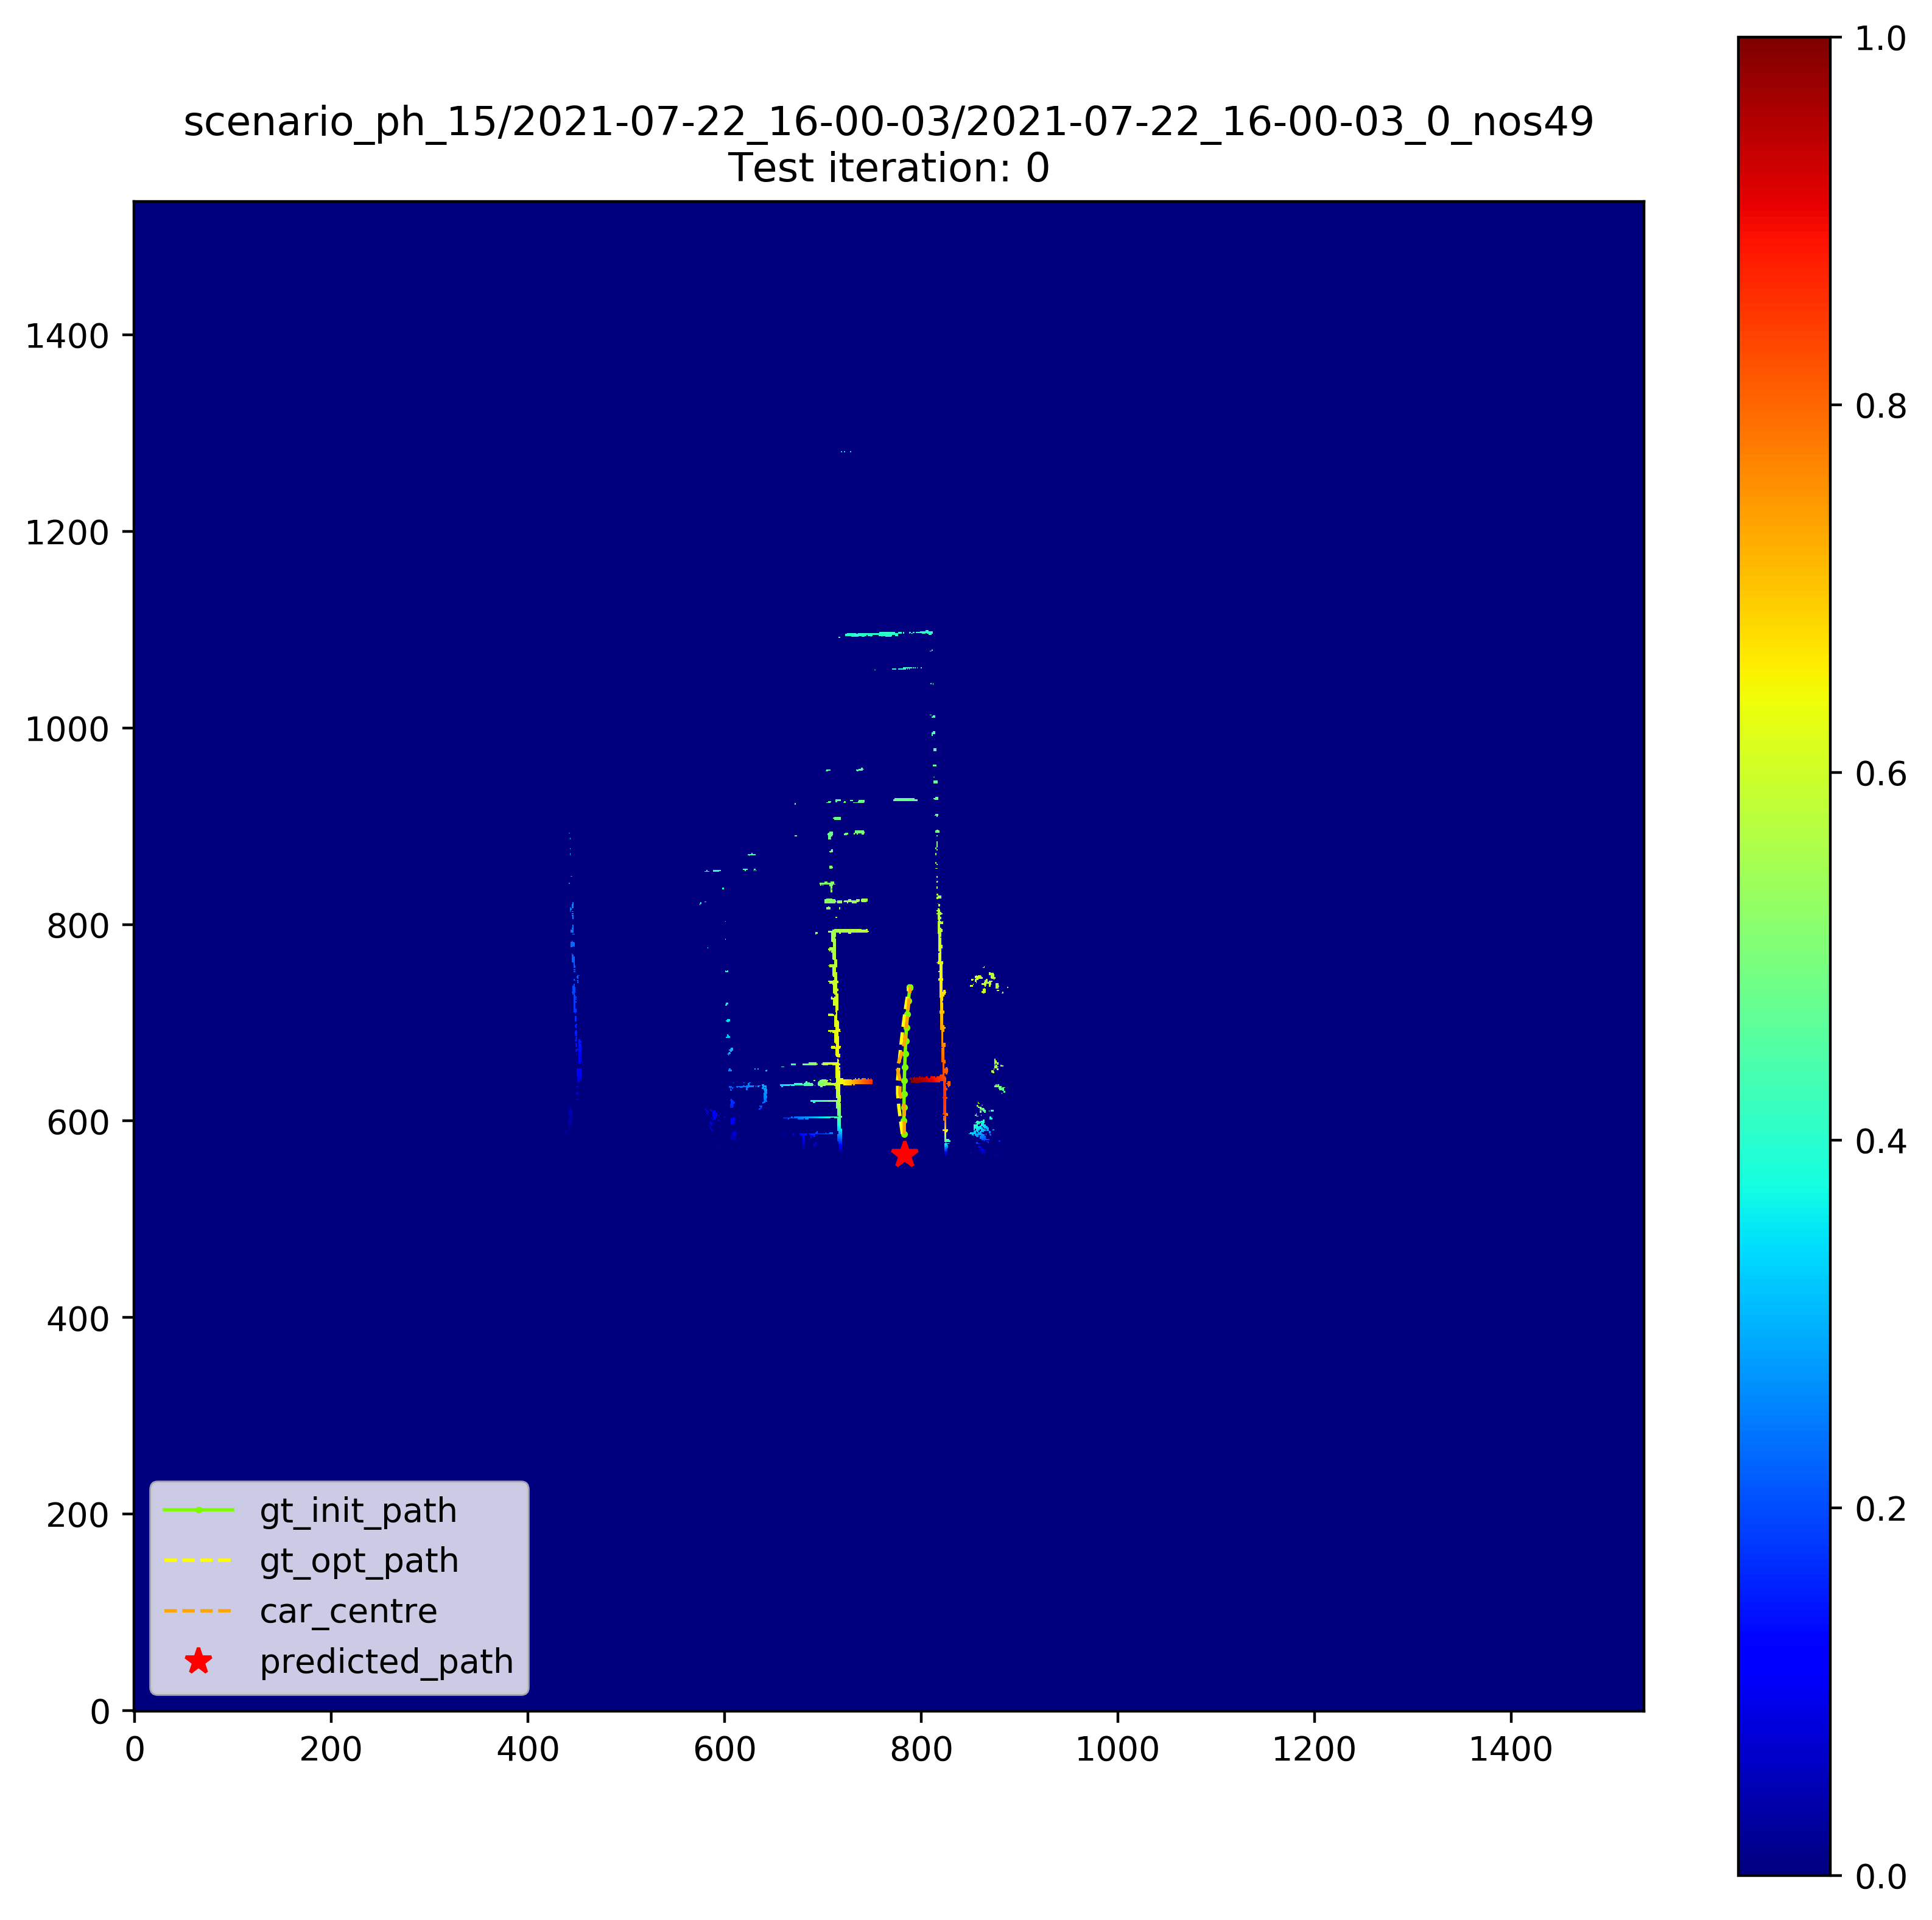

In [76]:
def iter_plot_sample(save,cost_map:ndarray,init_path:ndarray,opt_path:ndarray,predicted_path:ndarray,car_odo:ndarray,file_details,itn):
    norm_fac = 1536
    plt.figure(figsize=(10,10),dpi=400)
    
    plt.imshow(cost_map.astype(float),origin='lower',cmap='jet')
    plt.colorbar()
    plt.plot(
        init_path[:, 0]*norm_fac,
        init_path[:, 1]*norm_fac,
        "o-",
        color="lawngreen",
        markersize=1,
        linewidth=1,
    )
    plt.plot(
        opt_path[:, 0]*norm_fac,
        opt_path[:, 1]*norm_fac,
        "--",
        color="yellow",
        markersize=1,
        linewidth=1,
    )
    plt.plot(
        predicted_path[:, 0]*norm_fac,
        predicted_path[:, 1]*norm_fac,
        "--",
        color="orange",
        markersize=1,
        linewidth=1,
    )
    plt.plot(car_odo[0] *norm_fac,car_odo[1] *norm_fac,
        "r*",
        color="red",
        markersize=8,
    )

    file_name = file_details.numpy().decode('utf-8').replace("cm_fv_paths_odo_unequal.npz","")
    plt.title(f"{file_name}\nTest iteration: {itn}")
    plt.legend(['gt_init_path', 'gt_opt_path','car_centre', 'predicted_path'], loc='lower left')
    
    split_details = os.path.split(file_name)[0]
    scene_name = os.path.split(split_details)[0]
    save_dir_root='/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/test_results/iter_results'
    model_name = wandbmodel_path.split("/")[-3]
    # directory t save 
    save_dir = os.path.join(save_dir_root,model_name,scene_name)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    if save:
        plt.savefig(f"{save_dir}/Test_index_{idx}_iter_{itn}.png",dpi=300)
        plt.close()
    #plt.show()

for itn in trange(1):
    model_output = load_wandb.predict(np.expand_dims(sample_fv,axis=0))
    pred_path = (sample_init -model_output)[0]
    iter_plot_sample(save=False,cost_map=sample_gm,init_path=sample_init,opt_path=sample_opt, predicted_path=pred_path, car_odo=sample_odo, file_details = sample_file_details,itn=itn)

    sample_init = pred_path
    sample_fv = get_feature_vector(gridmap=sample_gm,init_path=sample_init*1536,offset=[13,20])




## Plotting and saving

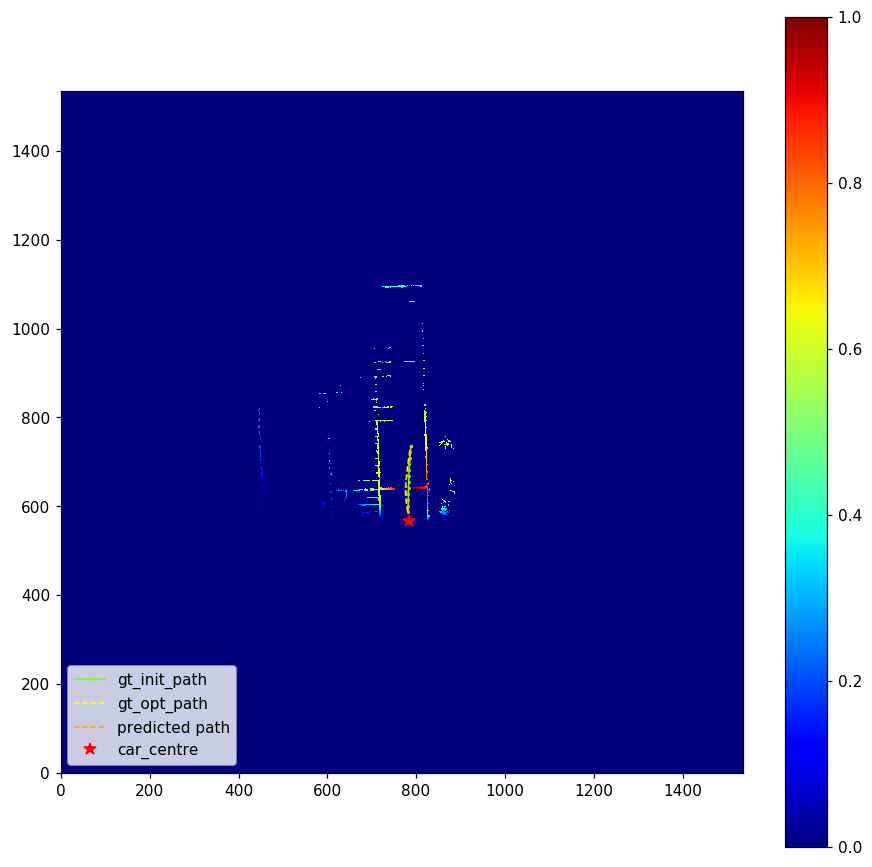

In [10]:
normalized_factor=1536
idx=48    
plt.figure(figsize=(10,10),dpi=110)
plt.imshow(cost_map[idx].astype(float),origin='lower',cmap='jet')
plt.colorbar()
plt.plot(
    init_path[idx][:, 0]*normalized_factor,
    init_path[idx][:, 1]*normalized_factor,
    "o-",
    color="lawngreen",
    markersize=1,
    linewidth=1,
)
plt.plot(
    opt_path[idx][:, 0]*normalized_factor,
    opt_path[idx][:, 1]*normalized_factor,
    "--",
    color="yellow",
    markersize=1,
    linewidth=1,
)

plt.plot(
    predicted_paths[idx][:, 0]*normalized_factor,
    predicted_paths[idx][:, 1]*normalized_factor,
    "--",
    color="orange",
    markersize=1,
    linewidth=1,
)
plt.plot(car_odo[idx][0] *normalized_factor,car_odo[idx][1] *normalized_factor,
    "r*",
    color="red",
    markersize=8,
)
plt.legend(['gt_init_path', 'gt_opt_path', 'predicted path','car_centre'], loc='lower left')
plt.show()
file_name = file_details[idx].numpy().decode('utf-8').replace("cm_fv_paths_odo_unequal.npz","")


In [84]:
model_name = wandbmodel_path.split("/")[-3]#'bgm_LSTM_2_50'#wandbmodel_path.split("/")[-3]
#'TDD_64_first'#wandbmodel_path.split("/")[-3]#'TDD_4_2'
save_dir_root = '/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/test_results/feature_vec_res'

#%matplotlib agg
#idx= 23#35#23#54#50#25#122#82#42#48
normalized_factor=1536

for idx in trange(predicted_paths.shape[0]):
    plt.figure(figsize=(10,10),dpi=200)
    plt.imshow(cost_map[idx].astype(float),origin='lower',cmap='jet')
    plt.colorbar()
    plt.plot(
        init_path[idx][:, 0]*normalized_factor,
        init_path[idx][:, 1]*normalized_factor,
        "o-",
        color="lawngreen",
        markersize=1,
        linewidth=1,
    )
    plt.plot(
        opt_path[idx][:, 0]*normalized_factor,
        opt_path[idx][:, 1]*normalized_factor,
        "--",
        color="yellow",
        markersize=1,
        linewidth=1,
    )

    plt.plot(
        predicted_paths[idx][:, 0]*normalized_factor,
        predicted_paths[idx][:, 1]*normalized_factor,
        "--",
        color="orange",
        markersize=1,
        linewidth=1,
    )
    plt.plot(car_odo[idx][0] *normalized_factor,car_odo[idx][1] *normalized_factor,
        "r*",
        color="red",
        markersize=8,
    )
    plt.legend(['gt_init_path', 'gt_opt_path', 'predicted path','car_centre'], loc='lower left')

    file_name = file_details[idx].numpy().decode('utf-8').replace("cm_fv_paths_odo_unequal.npz","")
    plt.title(f"{file_name}\nTest Index: {idx}")

    split_details = os.path.split(file_name)[0]
    scene_name = os.path.split(split_details)[0]
    
    # directory t save 
    save_dir = os.path.join(save_dir_root,model_name,scene_name)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    plt.savefig(f"{save_dir}/Test_index_{idx}.png",dpi=200)
    plt.close()

100%|██████████| 144/144 [01:08<00:00,  2.10it/s]


In [ ]:
np.unique(feature_v[idx])

In [ ]:
for i in range(init_path.shape[0]):
    print(np.allclose(init_path[i],opt_path[i],rtol=1e-05, atol=1e-07))